In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
print("Installations complete!")

Installations complete!


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
import pandas as pd
findspark.init()

from pyspark import SparkConf, SparkContext

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext, Row
from pyspark.sql import DataFrame
from pyspark.sql import functions as F  
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, count, size, expr, year, corr
from pyspark.sql.functions import month, count, sum

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline


In [ ]:
spark = SparkSession.builder \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#csv_url1 = "https://raw.githubusercontent.com/andrewhamaty/BDA-Final-Project-Repo/main/diabetes_012_health_indicators_BRFSS2015.csv?token=GHSAT0AAAAAACDIE5UPS24LXB2LINVYMN5IZDVE53Q"

df = spark.read.csv("/content/drive/Shareddrives/BDA_Academic_Weapons/Final Project/diabetes_binary_health_indicators_BRFSS2015.csv", header=True, inferSchema=True)

df.printSchema()
df.show(5)

root
 |-- Diabetes_binary: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)

+---------------+------+--------+---------+----+------+------+--------------------+------------+---

# Descriptive Analytics

In [ ]:
## Checking for data imbalance
class_counts = df.groupBy('Diabetes_binary').count()

total_count = df.count()
class_percentages = class_counts.withColumn('percentage', (col('count') / total_count) * 100)

# Display the class percentages
class_percentages.show()

+---------------+------+------------------+
|Diabetes_binary| count|        percentage|
+---------------+------+------------------+
|            0.0|218334| 86.06669820245979|
|            1.0| 35346|13.933301797540206|
+---------------+------+------------------+



The data has a class ratio of diabetic to non-diabetic is 14:86 which suggests that there is no severe data imbalance

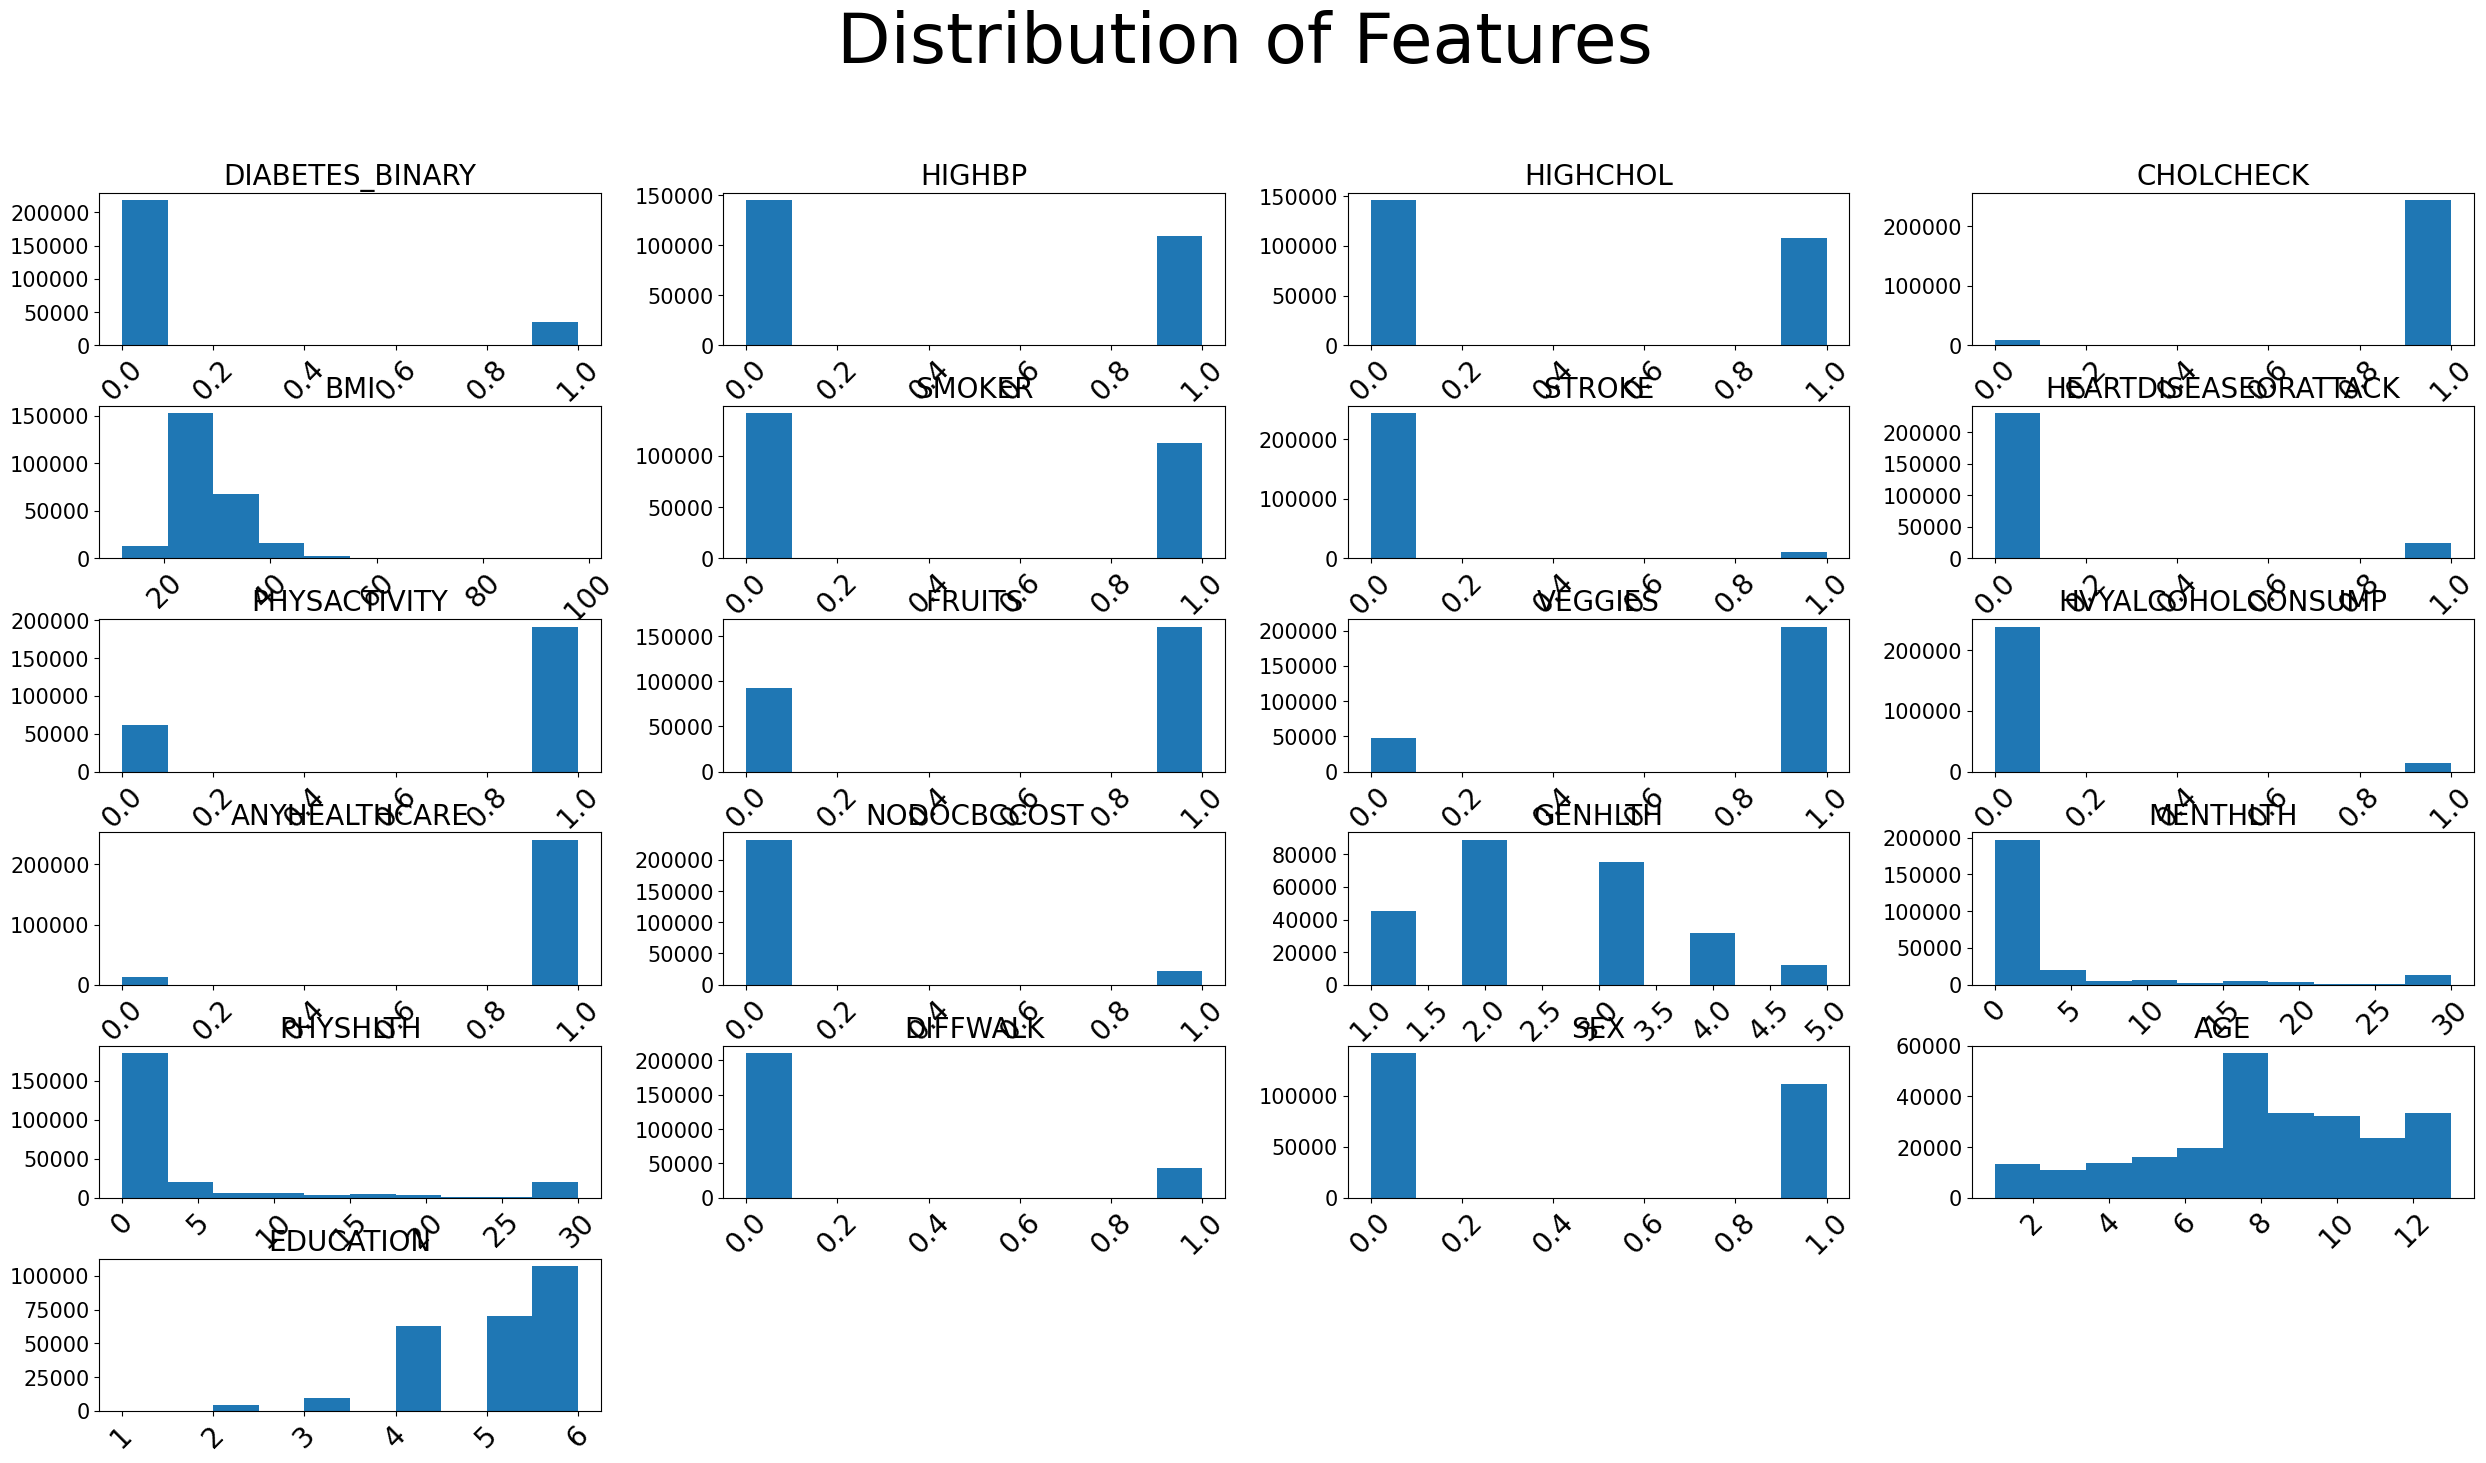

In [ ]:
from matplotlib import cm
import matplotlib.pyplot as plt

fig = plt.figure(figsize= (25,15)) ## Plot Size
st = fig.suptitle( "Distribution of Features", fontsize=50,
verticalalignment='center') # Plot Main Title
for col, num in zip (df.toPandas ( ). describe () .columns, range (1, 22)):
  ax = fig.add_subplot (6,4, num)
  ax.hist (df.toPandas () [col])
  #plt.style.use ('dark background' )
  plt.grid (False)
  plt.xticks (rotation=45,fontsize=20)
  plt.yticks (fontsize=15) 
  plt.title(col.upper (), fontsize=20) 
plt.tight_layout ()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show ()

## Predictive Analytics

In [ ]:
## Running the logistic regression: 

In [ ]:
feature_columns = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                   'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
                   'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Create a LogisticRegression model with L1 regularization (Lasso)
logistic_lasso = LogisticRegression(labelCol='Diabetes_binary', featuresCol='features', elasticNetParam=1.0)

# Create a pipeline to chain the VectorAssembler and LogisticRegression stages
pipeline = Pipeline(stages=[assembler, logistic_lasso])

# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)

# Fit the pipeline on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Display the predictions
predictions.show()

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+--------------------+--------------------+--------------------+----------+
|Diabetes_binary|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|            features|       rawPrediction|         probability|prediction|
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+--------------------+--------------------+--------------------+----------+
|            0.0|   0.0|     0.0|      0.0|16.0|   0.0|   0.0|                 0.0|         1.0|   0.0|    1.0|              0.

In [ ]:
## Saving the results in a csv 
predictions_output = predictions.toPandas()

# Specify the file path and name for the CSV file
csv_file_path = '/content/drive/Shareddrives/BDA_Academic_Weapons/Final Project/predictions.csv'

# Save the Pandas DataFrame as a CSV file
predictions_output.to_csv(csv_file_path, index=False)

### Top 4 predictors for diabetes

In [ ]:
coefficients = model.stages[-1].coefficients.tolist()  # Convert to Python list

# Create a list of tuples containing the predictor names and their corresponding coefficients
coefficients_list = list(zip(feature_columns, coefficients))



# Create a DataFrame from the coefficients list
coefficients_df = pd.DataFrame(coefficients_list, columns=['Predictor', 'Coefficient'])

# Convert the Coefficient column to float
coefficients_df['Coefficient'] = coefficients_df['Coefficient'].astype(float)

# Sort the DataFrame by the absolute value of the Coefficient column in descending order
sorted_coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

# Retrieve the top 3-4 most important predictors
top_predictors = sorted_coefficients_df['Predictor'].head(4)

# Display the top predictors
print("Top Predictors:")
for predictor in top_predictors:
    print(predictor)



Top Predictors:
CholCheck
HvyAlcoholConsump
HighBP
HighChol


CholCheck = Ever Had Blood Cholesterol Checked

## Feature importance (Odds Ratio)

In [ ]:
feature_importance = model.stages[-1].coefficients

# Print the feature coefficients
for i, feature in enumerate(feature_columns):
    importance = feature_importance[i]
    print(f"Feature: {feature}, Importance: {importance}")

Feature: HighBP, Importance: 0.7762259542506471
Feature: HighChol, Importance: 0.5604282039470471
Feature: CholCheck, Importance: 1.2482631989555952
Feature: BMI, Importance: 0.06216369116710026
Feature: Smoker, Importance: -0.004374205689513044
Feature: Stroke, Importance: 0.12585495139221575
Feature: HeartDiseaseorAttack, Importance: 0.20722317744994667
Feature: PhysActivity, Importance: -0.04162541551702249
Feature: Fruits, Importance: -0.045910349726191034
Feature: Veggies, Importance: -0.04097218973839442
Feature: HvyAlcoholConsump, Importance: -0.796852412762912
Feature: AnyHealthcare, Importance: 0.06288747682028029
Feature: NoDocbcCost, Importance: 0.01112057559567339
Feature: GenHlth, Importance: 0.5309858348083834
Feature: MentHlth, Importance: -0.003527325024030454
Feature: PhysHlth, Importance: -0.006521968896100079
Feature: DiffWalk, Importance: 0.11157919969426983
Feature: Sex, Importance: 0.26721910547556516
Feature: Age, Importance: 0.125771069391076
Feature: Education,

## Performance Metrics

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Extract the true labels and predicted labels from the predictions DataFrame
predictionAndLabels = predictions.select('prediction', 'Diabetes_binary').rdd

# Instantiate a MulticlassMetrics object with the predictionAndLabels RDD
metrics = MulticlassMetrics(predictionAndLabels)

# Compute the confusion matrix
confusion_matrix = metrics.confusionMatrix()

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

# Compute performance metrics
accuracy = metrics.accuracy  # Removed the parentheses here
precision = metrics.weightedPrecision # Compute precision for all classes
recall = metrics.weightedRecall  # Compute recall for all classes
f1Score = metrics.weightedFMeasure  # Compute F1 score for all classes

# Display performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1Score)


Confusion Matrix:
DenseMatrix([[63804.,  1439.],
             [ 8959.,  1669.]])
Accuracy: 0.8629515888811272
Precision: 0.8292648762643247
Recall: 0.8629515888811272
F1 Score: <bound method MulticlassMetrics.weightedFMeasure of <pyspark.mllib.evaluation.MulticlassMetrics object at 0x7f321b056590>>


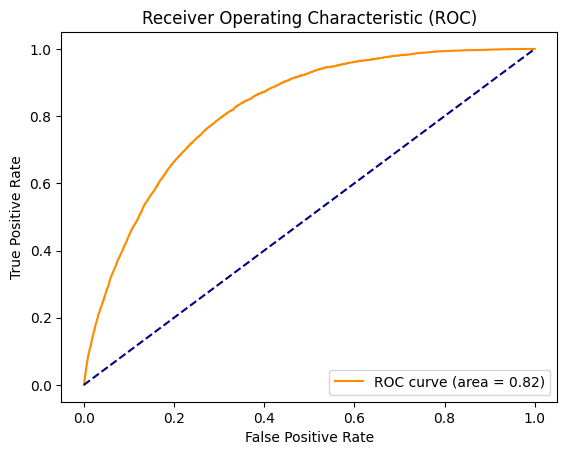

In [ ]:
# Compute the probabilities and labels
from sklearn.metrics import roc_curve, auc
results = predictions.select(['Diabetes_binary', 'probability']).rdd.map(lambda row: (float(row['probability'][1]), float(row['Diabetes_binary'])))
scores_and_labels = results.collect()
probabilities, labels = zip(*scores_and_labels)

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(labels, probabilities)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Looping over each age group

In [ ]:
# Selecting features
feature_columns = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                   'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
                   'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Create a LogisticRegression model with L1 regularization (Lasso)
logistic_lasso = LogisticRegression(labelCol='Diabetes_binary', featuresCol='features', elasticNetParam=1.0)

# Create a pipeline to chain the VectorAssembler and LogisticRegression stages
pipeline = Pipeline(stages=[assembler, logistic_lasso])

# List of age categories
age_categories = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

for age_category in age_categories:
    # Filter the DataFrame for the current age category
    filtered_data = df.filter(df.Age == age_category)

    # Split the filtered data into training and testing sets
    train_data, test_data = filtered_data.randomSplit([0.7, 0.3], seed=123)

    # Fit the pipeline on the training data
    model = pipeline.fit(train_data)

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Display the predictions
    predictions.show()

    # Extract the true labels and predicted labels from the predictions DataFrame
    predictionAndLabels = predictions.select('prediction', 'Diabetes_binary').rdd

    # Instantiate a MulticlassMetrics object with the predictionAndLabels RDD
    metrics = MulticlassMetrics(predictionAndLabels)

    # Compute the confusion matrix
    confusion_matrix = metrics.confusionMatrix()

    # Display the confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix)

    # Compute performance metrics
    accuracy = metrics.accuracy
    precision = metrics.weightedPrecision
    recall = metrics.weightedRecall
    f1Score = metrics.weightedFMeasure

    # Display performance metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1Score)

    # Compute the probabilities and labels
    results = predictions.select(['Diabetes_binary', 'probability']).rdd.map(lambda row: (float(row['probability'][1]), float(row['Diabetes_binary'])))
    scores_and_labels = results.collect()
    probabilities, labels = zip(*scores_and_labels)

    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, probabilities)

    # Compute the AUC
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()